## Define natural priors

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'pdf')

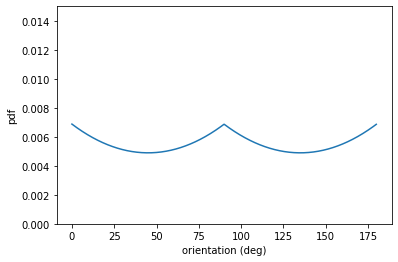

In [2]:
# "Natural prior" (Girshick et al. 2011, fig.6)
n_ori = 1000
a = 2e-4
b = 1

dori = 180 / n_ori
stim_dirs = np.float32(np.arange(0, 180, dori))
stim_p = np.zeros(n_ori)
midindx = np.argmin(np.abs(stim_dirs-90))

stim_p[:midindx] = a*(np.arange(0, stim_dirs[midindx], stim_dirs[midindx] / midindx)-45)**2 + b
stim_p[midindx:] = a*(np.arange(stim_dirs[midindx+1],
                               180, (180-stim_dirs[midindx+1]) / (n_ori-midindx)
                              )-135)**2 + b
plt.figure()
stim_p = stim_p/np.sum(stim_p)
plt.plot(stim_dirs,stim_p/dori)
plt.ylim([0,0.015])
plt.xlabel('orientation (deg)')
plt.ylabel('pdf')

## Train network from stimuli distributed with the natural statistics

In [3]:
import sys, os, time

import copy
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
from det_rnn import *
import det_rnn.train as utils_train
import det_rnn.analysis as utils_analysis
import tensorflow as tf
from det_rnn.train.model import Model
from utils.plotfnc import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

model_dir = "../experiments/naturalprior/200622/"
os.makedirs(model_dir, exist_ok=True)

2.3.0-dev20200519
Num GPUs Available:  0


### Generate stimulus

In [4]:
# training set
par_train = copy.deepcopy(par)
# use "natural prior"
par_train['stim_dist'] = 'natural'
par_train['natural_a'] = 2e-4
par_train['n_ori'] = 1000 # make it somewhat continuous
par_train = update_parameters(par_train)
stim_train = Stimulus(par_train)

# testing set; for testing the 24 orientations
par_test = copy.deepcopy(par)
par_test = update_parameters(par_test)
stim_test = Stimulus(par_test)   # the argument `par` may be omitted

orientation = 49.68


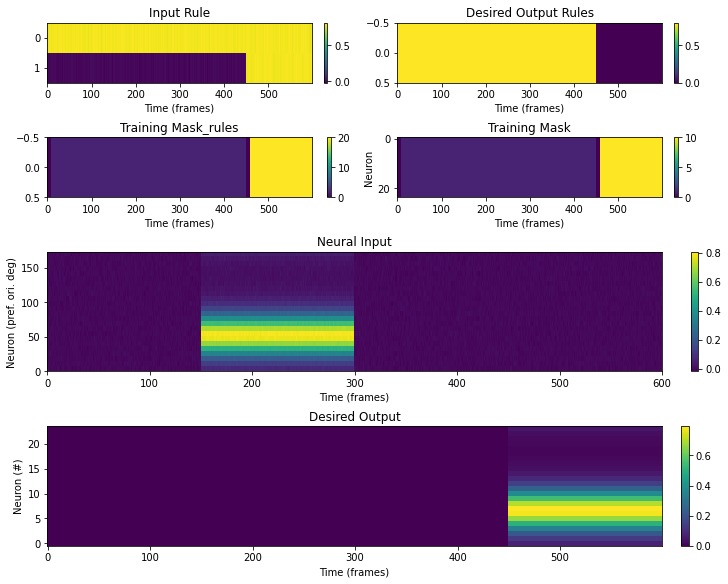

In [5]:
# check stimulus
train_data = stim_train.generate_trial()
random_trial_num = np.random.randint(stim_train.batch_size)
target_ori = np.arange(0,180,180/par_train['n_ori'])[train_data['stimulus_ori'][random_trial_num]]
print('orientation = ' + str(target_ori))
plot_trial(stim_train, train_data,TEST_TRIAL=random_trial_num)

orientation = 172.5


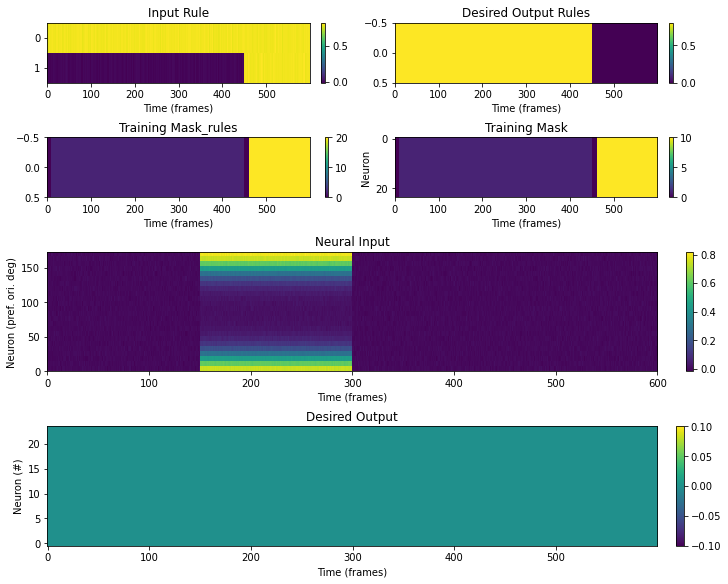

In [13]:
test_data = stim_test.generate_trial(balanced=True)
random_trial_num = len(test_data['stimulus_ori'])-2
#random_trial_num = np.random.randint(len(test_data['stimulus_ori']))
target_ori = np.arange(0,180,180/par_test['n_ori'])[test_data['stimulus_ori'][random_trial_num]]
print('orientation = ' + str(target_ori))
plot_trial(stim_test, test_data,TEST_TRIAL=random_trial_num)

In [ ]:
###### Train network ######
N_iter = 3000
N_save = 50  # save model every N_save iterations

# define model
hp = utils_train.hp
hp['learning_rate'] = 5e-1
model = Model(hp=hp)

ti_spec = utils_train.gen_ti_spec(stim_train.generate_trial())

In [ ]:
alllosses =[]
performance_train = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
performance_test = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}

for iter_n in range(N_iter+1):
    # train on testing set
    train_data = utils_train.tensorize_trial(stim_train.generate_trial())
    Y, Loss = model(train_data, hp)

    performance_train = utils_train.append_model_performance(performance_train,
                                                             train_data, Y, Loss, par_train)
    # append performance on testing set
    test_data = utils_train.tensorize_trial(stim_test.generate_trial(balanced=True))
    test_Y, test_loss = model.return_losses(test_data['neural_input'], test_data['desired_output'],
                                            test_data['mask'], hp)
    performance_test = utils_train.append_model_performance(performance_test,
                                                            test_data, test_Y, test_loss, par_test)

    if (iter_n % N_save) == 0:
        print('\n Training performance: ')
        utils_train.print_results(performance_train, iter_n)

        # predict from testing set
        print('Testing performance: ')
        utils_train.print_results(performance_test, iter_n)
        plot_rnn_output(par_test, test_data, test_Y, stim_test, TEST_TRIAL=None)

        test_Y = utils_analysis.softmax_pred_output(test_Y) # change to softmax
        ground_truth, estim_mean, raw_error, beh_perf = utils_analysis.behavior_summary(test_data, test_Y, par=par_test)
        utils_analysis.behavior_figure(ground_truth, estim_mean, raw_error, beh_perf)

        tf.saved_model.save(model, os.path.join(model_dir, "cont_iter" + str(iter_n)))

    # save final model
    if iter_n == N_iter:
        tf.saved_model.save(model, os.path.join(model_dir, "cont_iter" + str(iter_n)))
